In [1]:
import os
import warnings

warnings.filterwarnings('ignore')

### Getting Data

In [2]:
import nltk
import pandas as pd

nltk.download('gutenberg')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/andreychubin/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreychubin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/andreychubin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
body = []

for book in nltk.corpus.gutenberg.fileids()[:10]:
    text = nltk.corpus.gutenberg.raw(book)
    text = text.replace('\n', ' ')
    body.append(text)

print(f'Amount of documents: {len(body)}')
print(f'Appx. length of first document: {len(body[0].split(" "))} words')

Amount of documents: 10
Appx. length of first document: 164457 words


In [4]:
frame = pd.DataFrame(data=body, columns=['book_text'])

frame.head()

,book_text
0,[Emma by Jane Austen 1816] VOLUME I CHAPTER ...
1,[Persuasion by Jane Austen 1818] Chapter 1 ...
2,[Sense and Sensibility by Jane Austen 1811] C...
3,[The King James Bible] The Old Testament of t...
4,[Poems by William Blake 1789] SONGS OF INNO...


### Tokenizing-functions

In [5]:
import re
from nltk.stem import WordNetLemmatizer

wordnet = WordNetLemmatizer()

GROUPING_SPACE_REGEX = re.compile(r'([^\w]|[+])', re.UNICODE)

def simple_word_tokenizer(text, _split=GROUPING_SPACE_REGEX.split):
    return [t for t in _split(text.lower()) if t and not t.isspace()]

def token_r(text):
    words = simple_word_tokenizer(text)
    return [wordnet.lemmatize(x, pos='v') for x in words if len(x) > 1]

In [6]:
test = 'He went to Dublin and drunk 10 bottles of beer'

token_r(test)

['he', 'go', 'to', 'dublin', 'and', 'drink', '10', 'bottle', 'of', 'beer']

### Word Count in Pyspark

In [7]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [8]:
conf = SparkConf()

conf.setAll(
    [
        ("spark.app.name", "Andrey Chubin Word Count"),
        ("spark.master", "local[*]")
    ]
)

spark = SparkSession\
    .builder\
    .config(conf=conf)\
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/12 16:22:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
spark

In [10]:
spark_df = spark.createDataFrame(frame)

spark_df.show(5)

22/03/12 16:23:02 WARN TaskSetManager: Stage 1 contains a task of very large size (4272 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+
|           book_text|
+--------------------+
|[Emma by Jane Aus...|
|[Persuasion by Ja...|
|[Sense and Sensib...|
|[The King James B...|
|[Poems by William...|
+--------------------+
only showing top 5 rows



In [11]:
counted = spark_df.rdd\
    .flatMap(lambda row: token_r(row.book_text))\
    .map(lambda word: (word, 1))\
    .reduceByKey(lambda a, b: a+b)\
    .sortBy(lambda x: x[1], ascending=False)

22/03/12 16:23:04 WARN TaskSetManager: Stage 2 contains a task of very large size (4272 KiB). The maximum recommended task size is 1000 KiB.


In [12]:
counted.take(10)

[('the', 92485),
 ('and', 71606),
 ('be', 52283),
 ('of', 51571),
 ('to', 31170),
 ('in', 22195),
 ('that', 20276),
 ('he', 18855),
 ('have', 16614),
 ('it', 15110)]

In [13]:
counted_list = counted.collect()

In [14]:
counted_df = pd.DataFrame(
    {
        'word': [x[0] for x in counted_list],
        'count': [x[1] for x in counted_list]
    }
)

In [15]:
counted_df.head()

,word,count
0,the,92485
1,and,71606
2,be,52283
3,of,51571
4,to,31170


<AxesSubplot:ylabel='Density'>

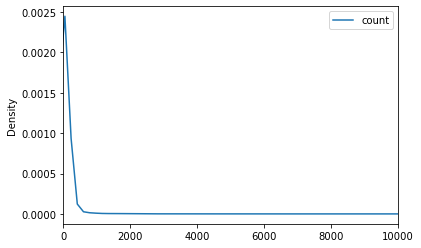

In [16]:
counted_df.plot(x='word', y='count', kind='kde', xlim=(0, 10000))

On a graph we can see that only a small fraction of words are really frequent, other are relatively seldom to meet. This is a usuall distribution for words and this distribution is utilized by TF-IDF approach with assumption that rare words have more meaning (for ml-models) than frequent ones.

In [17]:
counted.saveAsTextFile('wordcount')

In [18]:
spark.stop()

### Merge output files to one

In [19]:
path = '/Users/andreychubin/Desktop/ВШЭ/НИС_2'

os.system(f"cat {path}/wordcount/* > {path}/wordcount.txt")

0

### Prepare requirements.txt

In [20]:
!conda env export -n pyspark > environment.yml